# Noteboot for all of out amazing ideas


In [5]:
#imports
import torch
import copy
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gym
from collections import deque
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [6]:
# This is the 'standard' neural network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)



In [7]:
def test_pole_length(env, q_network):
    """
    This function runs your trained network on a specific pole length
    You are not allowed to change this function
    """

    wind = 25
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    done = False
    total_reward = 0


    while not done:

        action = q_network(state).argmax().item()
        next_state, reward, done, _, __ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        state = next_state
        total_reward += reward

        if total_reward >= 500 and total_reward <= 1000:
            if total_reward % wind == 0:

                env.unwrapped.force_mag = 75

        if total_reward > 1000:
            env.unwrapped.force_mag = 25 + (0.01 * total_reward)

    return total_reward

In [8]:
Transition = namedtuple('Transition', 
                        ('observation', 'action', 'next_observation', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """save a transtion"""
        self.memory.append(Transition(*args))
        #print(self.memory)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) 
    
    def __len__(self):
        return len(self.memory)

In [9]:
def pick_action(epsilon, policy_net, env, obs):
    p = random.uniform(0,1)
    if p < epsilon:
        action = env.action_space.sample()
    else:
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32)

        if obs.ndim == 1:
            obs = obs.unsqueeze(0)

        with torch.no_grad():
            q_values = policy_net(obs)
            action = torch.argmax(q_values).item()
    return action

def error(current_q, td_target, error_type):
    if error_type == "mse":
        #error = (current_q - td_target) ** 2
        compute_loss = nn.MSELoss()
        error = compute_loss(current_q, td_target)
    
    return error


In [10]:
def sample_batch(replay_buffer, batch_size):
    """Return tensors for observations, actions, rewards, next_observations, dones"""
    transitions = replay_buffer.sample(batch_size)
    batch = Transition(*zip(*transitions))

    obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.observation])
    next_obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.next_observation])
    a = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1)
    r = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1)
    done = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1)
    
    return obs, a, r, next_obs, done


In [11]:
def baseline_DQN(learning_rate, gamma, episodes, target_update, epsilon, capacity, batch_size):

    # Initialize the policy network and optimizer
    env = gym.make('CartPole-v1')
    observation, _ = env.reset()
    policy_net = QNetwork(state_dim=4, action_dim=2)
    target_net = QNetwork(state_dim=4, action_dim=2)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    plot_avg_rewards = []

    replay_buffer = ReplayMemory(capacity=capacity) #initialize buffer
    step_count = 0 #global step count
    total_reward = 0
    
    # Training loop
    for episode in range(episodes):
        observation, _ = env.reset() #observation for first action
        observation = torch.tensor(observation, dtype=torch.float32)
        terminated = False
        truncated = False 
        # inside training loop before each episode
        length = float(np.random.uniform(0.4, 1.8))
        env.unwrapped.length = length

        #step_count = 0

          
        while not terminated and not truncated:

            #perform an action, get env response
            action = pick_action(epsilon, policy_net, env, observation)
            next_observation, reward, terminated, truncated, __ = env.step(action)
            next_observation = torch.tensor(next_observation, dtype=torch.float32) 
            total_reward += reward

            #add new data to buffer
            replay_buffer.push(observation, action, next_observation, reward, terminated) 


            #do random steps until buffer has at least reached the batch_size
            if len(replay_buffer) < batch_size:
                step_count += 1
                continue 

            obs, a , r, obs_next, done = sample_batch(replay_buffer, batch_size)


            #update target network
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

            step_count += 1
        
        
            next_q_values = target_net(obs_next)
            next_q_max = next_q_values.max(dim=1, keepdim=True)[0].detach()
            td_target = r + gamma * (1-done) * next_q_max

            current_q = policy_net(obs).gather(1, a)

            loss = error(current_q, td_target, "mse")
            
            #to see of weights are updating later
            #old_weights = [p.clone() for p in policy_net.parameters()]


            #update weights of the NN/policy
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #tests if td_target is detatched - SHOULD NOT PRINT ANYTHING if it's implemented correctly
            for name, param in target_net.named_parameters():
                if param.grad is not None:
                    print(f"{name} has gradient!")

            #check if weights are updating
            # weight_diffs = [ (p - old_p).abs().mean().item() for p, old_p in zip(policy_net.parameters(), old_weights) ]
            # print("Average weight change per param:", weight_diffs)


            #update observation and decay epsilon for the next step
            observation = next_observation
            epsilon = max(0.01, 0.995 * epsilon) # decay epsilon


        if episode % 25 == 0:
            # calculate the avg rewards of the last 25 steps
            average = total_reward / 25
            plot_avg_rewards.append(average)
            #print(f'epsilon={epsilon:.3f}, total_reward={total_reward}')
            total_reward = 0
        
        if episode % 100 == 0:
            print(f'Episode {episode}/{episodes}')

    
    env.close()
    os.makedirs("weights", exist_ok=True)
    model_path = "weights/baseline_model2.pth"
    torch.save(policy_net.state_dict(), model_path)
    
    return plot_avg_rewards, policy_net


In [12]:
def plot_results(learning_rate, gamma, episode, result):

    result = np.array(result)
    
    y = [25*i for i in range(len(result))]
    y_axis = np.array(y)

    #plot graph
    plt.plot(y_axis, result)
    plt.xlabel('Number of Episodes')
    plt.ylabel('Reward')
    plt.title('Average rewards, Learning Rate: {}, Gamma: {}, Episode: {}'.format(learning_rate, gamma, episode))
    plt.show()

    pass

Episode 0/2000


C:\Users\sanne\AppData\Local\Temp\ipykernel_497296\2806284355.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.observation])
C:\Users\sanne\AppData\Local\Temp\ipykernel_497296\2806284355.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_obs = torch.stack([torch.tensor(o, dtype=torch.float32) for o in batch.next_observation])


Episode 100/2000
Episode 200/2000
Episode 300/2000
Episode 400/2000
Episode 500/2000
Episode 600/2000
Episode 700/2000
Episode 800/2000
Episode 900/2000
Episode 1000/2000
Episode 1100/2000
Episode 1200/2000
Episode 1300/2000
Episode 1400/2000
Episode 1500/2000
Episode 1600/2000
Episode 1700/2000
Episode 1800/2000
Episode 1900/2000


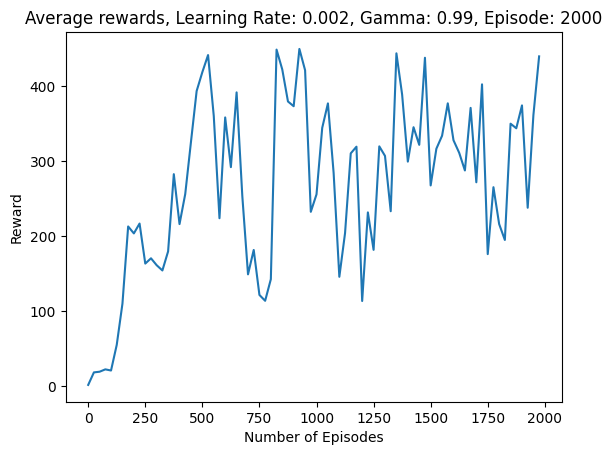

In [19]:
learning_rate = 0.002
gamma = 0.99
episodes = 2000
target_update = 500
epsilon = 1
capacity = 50000
batch_size = 64
plot_avg_rewards, baseline_network = baseline_DQN(learning_rate, gamma, episodes, target_update, epsilon, capacity, batch_size)

plot_results(learning_rate, gamma, episodes, plot_avg_rewards)

In [21]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        capacity: max number of transitions
        alpha: controls how much prioritization is used (0 = uniform sampling)
        """
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.alpha = alpha

    def __len__(self):
        return len(self.buffer)

    def push(self, observation, action, next_observation, reward, done):
        """Add a new transition with maximum priority (so it can be sampled soon)."""
        max_priority = max([t['priority'] for t in self.buffer], default=1.0)
        transition = {
            'observation': observation,
            'action': action,
            'next_observation': next_observation,
            'reward': reward,
            'done': done,
            'priority': max_priority
        }

        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        """Sample transitions based on priority."""
        priorities = np.array([t['priority'] for t in self.buffer], dtype=np.float32)
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        batch = [self.buffer[i] for i in indices]

        obs = torch.stack([t['observation'] for t in batch])
        actions = torch.tensor([t['action'] for t in batch], dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor([t['reward'] for t in batch], dtype=torch.float32).unsqueeze(1)
        next_obs = torch.stack([t['next_observation'] for t in batch])
        dones = torch.tensor([t['done'] for t in batch], dtype=torch.float32).unsqueeze(1)

        return batch, obs, actions, rewards, next_obs, dones

    def update_td_errors(self, batch, td_errors):
        """Update priorities based on absolute TD errors."""
        for transition, td_error in zip(batch, td_errors):
            td_abs = abs(td_error.item())
            transition['priority'] = max(td_abs, 1e-5)


In [23]:
def learning_progress_DQN(learning_rate=0.002, gamma=0.99, episodes=2000,
                          target_update=500, epsilon=1.0,
                          capacity=50000, batch_size=64):
    env = gym.make('CartPole-v1')
    observation, _ = env.reset()
    observation = torch.tensor(observation, dtype=torch.float32)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = QNetwork(state_dim, action_dim)
    target_net = QNetwork(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    plot_avg_rewards = []
    total_reward = 0
    step_count = 0

    # Initialize buffer
    replay_buffer = PrioritizedReplayBuffer(capacity=capacity)

    for episode in range(episodes):
        observation, _ = env.reset()
        observation = torch.tensor(observation, dtype=torch.float32)
        terminated = False
        truncated = False

        # Random pole length per episode
        env.unwrapped.length = float(np.random.uniform(0.4, 1.8))

        while not terminated and not truncated:
            # Pick action
            action = pick_action(epsilon, policy_net, env, observation)
            next_observation, reward, terminated, truncated, _ = env.step(action)
            next_observation = torch.tensor(next_observation, dtype=torch.float32)
            total_reward += reward

            # Push to buffer
            replay_buffer.push(observation, action, next_observation, reward, terminated)

            # Only update if enough samples
            if len(replay_buffer) >= batch_size:
                batch, obs, a, r, obs_next, done = replay_buffer.sample(batch_size)

                # Compute TD target
                next_q_max = target_net(obs_next).max(dim=1, keepdim=True)[0].detach()
                td_target = r + gamma * (1 - done) * next_q_max

                # Compute current Q
                current_q = policy_net(obs).gather(1, a)

                # Compute loss
                loss = error(current_q, td_target, "mse")

                # Update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update learning progress in buffer
                td_errors = (td_target - current_q).detach()
                replay_buffer.update_td_errors(batch, td_errors)

            # Update target network
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

            observation = next_observation
            epsilon = max(0.01, 0.995 * epsilon)
            step_count += 1

        # Logging
        if episode % 25 == 0:
            avg_reward = total_reward / 25
            plot_avg_rewards.append(avg_reward)
            total_reward = 0

        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes}")

    env.close()
    os.makedirs("weights", exist_ok=True)
    torch.save(policy_net.state_dict(), "weights/PER_model.pth")

    return plot_avg_rewards, policy_net

Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500


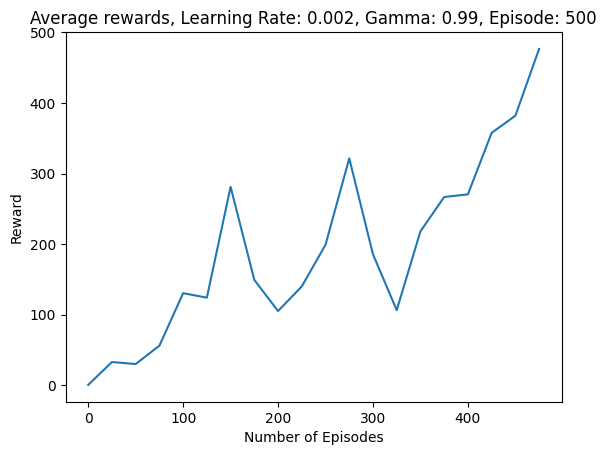

In [24]:
learning_rate = 0.002
gamma = 0.99
episodes = 500
target_update = 500
epsilon = 1
capacity = 50000
batch_size = 64
plot_avg_rewards, baseline_network = learning_progress_DQN(learning_rate, gamma, episodes, target_update, epsilon, capacity, batch_size)

plot_results(learning_rate, gamma, episodes, plot_avg_rewards)

In [37]:
class PERWithUsagePenalty:
    def __init__(self, capacity, alpha=0.8, beta_usage=0.05, epsilon = 0.05):
        """
        capacity: max number of transitions
        alpha: how strongly TD-error affects sampling probability (0 = uniform)
        beta_usage: gentle penalty factor for how often a transition has been used
        """
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.alpha = alpha
        self.beta_usage = beta_usage
        self.epsilon = epsilon

    def __len__(self):
        return len(self.buffer)

    def push(self, observation, action, next_observation, reward, done):
        """Add a new transition with max priority."""
        max_priority = max([t['priority'] for t in self.buffer], default=1.0)
        transition = {
            'observation': observation,
            'action': action,
            'next_observation': next_observation,
            'reward': reward,
            'done': done,
            'priority': max_priority,
            'uses': 0
        }
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            self.buffer[self.pos] = transition
            self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        """Sample transitions according to adjusted priority (TD-error × usage penalty)."""
        priorities = np.array([t['priority'] for t in self.buffer], dtype=np.float32)
        probs = priorities ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        batch = [self.buffer[i] for i in indices]
        N = len(self.buffer)
        probs = (1 - self.epsilon) * probs + self.epsilon * (1 / N)

        # Convert to tensors
        obs = torch.stack([t['observation'] for t in batch])
        actions = torch.tensor([t['action'] for t in batch], dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor([t['reward'] for t in batch], dtype=torch.float32).unsqueeze(1)
        next_obs = torch.stack([t['next_observation'] for t in batch])
        dones = torch.tensor([t['done'] for t in batch], dtype=torch.float32).unsqueeze(1)

        # Increment usage count (used for penalty in update)
        for t in batch:
            t['uses'] += 1

        return batch, obs, actions, rewards, next_obs, dones

    def update_td_errors(self, batch, td_errors):
        """Update priorities based on TD-error and usage penalty."""
        for transition, td_error in zip(batch, td_errors):
            td_abs = abs(td_error.item())
            # usage_penalty = 1 / (1 + self.beta_usage * transition['uses'])
            usage_penalty = np.exp(-self.beta_usage * transition['uses'])
            new_priority = td_abs * usage_penalty
            transition['priority'] = max(new_priority, 1e-5)  # avoid zero


In [36]:
def learning_progress_DQN(
    learning_rate=0.002,
    gamma=0.99,
    episodes=2000,
    target_update=500,
    epsilon=1.0,
    capacity=50000,
    batch_size=64,
    alpha=0.8,
    beta_usage=0.05,
    epsilon_usage=0.00,
):

    env = gym.make('CartPole-v1')
    observation, _ = env.reset()
    observation = torch.tensor(observation, dtype=torch.float32)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = QNetwork(state_dim, action_dim)
    target_net = QNetwork(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    plot_avg_rewards = []
    total_reward = 0
    step_count = 0

    # Initialize buffer
    replay_buffer = PERWithUsagePenalty(capacity=capacity, alpha=alpha, beta_usage=beta_usage, epsilon=epsilon_usage)

    for episode in range(episodes):
        observation, _ = env.reset()
        observation = torch.tensor(observation, dtype=torch.float32)
        terminated = False
        truncated = False

        # Random pole length per episode
        env.unwrapped.length = float(np.random.uniform(0.4, 1.8))

        while not terminated and not truncated:
            # Pick action
            action = pick_action(epsilon, policy_net, env, observation)
            next_observation, reward, terminated, truncated, _ = env.step(action)
            next_observation = torch.tensor(next_observation, dtype=torch.float32)
            total_reward += reward

            # Push to buffer
            replay_buffer.push(observation, action, next_observation, reward, terminated)

            # Only update if enough samples
            if len(replay_buffer) >= batch_size:
                batch, obs, a, r, obs_next, done = replay_buffer.sample(batch_size)

                # Compute TD target
                next_q_max = target_net(obs_next).max(dim=1, keepdim=True)[0].detach()
                td_target = r + gamma * (1 - done) * next_q_max

                # Compute current Q
                current_q = policy_net(obs).gather(1, a)

                # Compute loss
                loss = error(current_q, td_target, "mse")

                # Update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update learning progress in buffer
                td_errors = (td_target - current_q).detach()
                replay_buffer.update_td_errors(batch, td_errors)

            # Update target network
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

            observation = next_observation
            epsilon = max(0.01, 0.995 * epsilon)
            step_count += 1

        # Logging
        if episode % 25 == 0:
            avg_reward = total_reward / 25
            plot_avg_rewards.append(avg_reward)
            total_reward = 0

        if episode % 100 == 0:
            print(f"Episode {episode}/{episodes}")

    env.close()
    # os.makedirs("weights", exist_ok=True)
    # torch.save(policy_net.state_dict(), "weights/PER_usage_model.pth")

    return plot_avg_rewards, policy_net

Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500


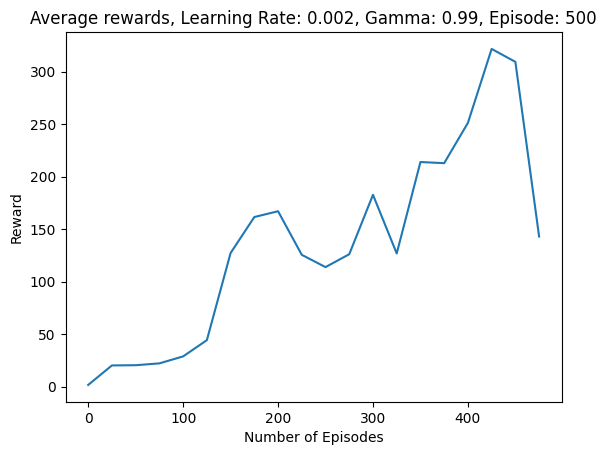

In [31]:
learning_rate = 0.002
gamma = 0.99
episodes = 500
target_update = 500
epsilon = 1
capacity = 50000
batch_size = 64
plot_avg_rewards, baseline_network = learning_progress_DQN(learning_rate, gamma, episodes, target_update, epsilon, capacity, batch_size)

plot_results(learning_rate, gamma, episodes, plot_avg_rewards)

In [ ]:
import itertools
import pandas as pd
import numpy as np

# Hyperparameter options
alpha_vals = [0.6, 0.8, 1.0]
beta_vals = [0.01, 0.05, 0.1]
epsilon_vals = [0.0, 0.05, 0.1]

# Store results
all_results = []

# Number of runs per combination
num_runs = 3

for alpha, beta, eps_usage in itertools.product(alpha_vals, beta_vals, epsilon_vals):
    run_rewards = []
    print(f"\nTraining with alpha={alpha}, beta_usage={beta}, epsilon_usage={eps_usage}")
    
    for run in range(num_runs):
        print(f"  Run {run + 1}/{num_runs}")
        plot_avg_rewards, _ = learning_progress_DQN(
            learning_rate=0.002,
            gamma=0.99,
            episodes=500,
            target_update=500,
            epsilon=1.0,
            capacity=50000,
            batch_size=64,
            alpha=alpha,
            beta_usage=beta,
            epsilon_usage=eps_usage
        )
        overall_avg = sum(plot_avg_rewards) / len(plot_avg_rewards)
        run_rewards.append(overall_avg)
    
    # Compute mean and std over runs
    mean_reward = np.mean(run_rewards)
    std_reward = np.std(run_rewards)
    
    all_results.append({
        "alpha": alpha,
        "beta_usage": beta,
        "epsilon_usage": eps_usage,
        "mean_reward": mean_reward,
        "std_reward": std_reward
    })

# Save results
df_results = pd.DataFrame(all_results)
df_results.to_excel("hyperparam_sweep_results.xlsx", index=False)
print("\nHyperparameter sweep complete! Results saved to 'hyperparam_sweep_results.xlsx'.")



Training with alpha=0.6, beta_usage=0.01, epsilon_usage=0.0
  Run 1/3
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500
  Run 2/3
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500
  Run 3/3
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500

Training with alpha=0.6, beta_usage=0.01, epsilon_usage=0.05
  Run 1/3
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500
  Run 2/3
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500
  Run 3/3
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500

Training with alpha=0.6, beta_usage=0.01, epsilon_usage=0.1
  Run 1/3
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500
  Run 2/3
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500
  Run 3/3
Episode 0/500
Episode 100/500
Episode 200/500
Episode 300/500
Episode 400/500

Training with alpha=0.6